In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
class Op(object):
  def __init__(self):
    self.gradients = [(v, self.deriv(v)) for v in self.variables]
    
  def __add__(self, b):
    return Add(self, b)
  
  def __sub__(self, b):
    return Sub(self, b)
  
  def __mul__(self, b):
    return Mul(self, b)
  
  def __truediv__(self, b):
    return Div(self, b)
  
  def __pow__(self, b):
    return Pow(self, b)
  
  def __neg__(self):
    return Neg(self)
  
  def dot(self, b):
    return Dot(self, b)
  
class UnaryOp(Op):
  def __init__(self, x):
    self.x = x
    self.variables = x.variables
   
class BinaryOp(Op):
  def __init__(self, a, b):
    self.a = a
    self.b = b
    self.variables = a.variables.union(b.variables)

In [3]:
class Add(BinaryOp):
  def eval(self, cache):
    if not self in cache:
      cache[self] = self.a.eval(cache) + self.b.eval(cache)
    
    return cache[self]
  
  def deriv(self, var):
    return self.a.deriv(var) + self.b.deriv(var)
  
class Sub(BinaryOp):
  def eval(self, cache):
    if not self in cache:
      cache[self] = self.a.eval(cache) - self.b.eval(cache)
    return cache[self]
  
  def deriv(self, var):
    return self.a.deriv(var) - self.b.deriv(var)
  
class Mul(BinaryOp):
  def eval(self, cache):
    if not self in cache:
      cache[self] = self.a.eval(cache) * self.b.eval(cache)
      
    return cache[self]
  
  def deriv(self, var):
    return (self.a * self.b.deriv(var)) + (self.b * self.a.deriv(var))
  
class Div(BinaryOp):
  def eval(self, cache):
    if not self in cache:
      cache[self] = self.a.eval(cache) / self.b.eval(cache)
      
    return cache[self]
  
  def deriv(self, var):
    return (self.b * self.a.deriv(var) - self.a * self.b.deriv(var)) / (self.b ** Const(2))
  
class Pow(BinaryOp):
  def eval(self, cache):
    if not self in cache:
      cache[self] = self.a.eval(cache) ** self.b.eval(cache)
    
    return cache[self]
  
  def deriv(self, var):
    return ((self.b * self.a) ** (self.b - Const(1))) * self.a.deriv(var)
  
class Neg(UnaryOp):
  def eval(self, cache):
    if not self in cache:
      cache[self] = -self.x.eval()
      
    return cache[self]
  
  def deriv(self, var):
    return -self.x.deriv(var)
  
class Dot(BinaryOp):
  def eval(self, cache):
    if not self in cache:
      cache[self] = self.a.eval(cache).dot(self.b.eval(cache))
      
    return cache[self]
  
  def deriv(self, var):
    return self.a.dot(self.b.deriv(var)) + self.a.deriv(var).dot(self.b)

#     print('---')
#     print(self.a.eval({}).shape, self.a.deriv(var).eval({}).shape)
#     print(self.b.eval({}).shape, self.b.deriv(var).eval({}).shape)
#     return Const(1)

In [22]:
class Const(Op):
  def __init__(self, value):
    self.value = np.array(value)
    self.variables = set()
    
  def eval(self, cache):
    return self.value
  
  def deriv(self, var):
    if var == self:
      return Const(np.ones(self.value.shape))
    else:
      return Const(np.zeros(self.value.shape))
    
class Variable(Op):
  def __init__(self, value):
    self.value = np.array(value)
    self.variables = set([self])
    
  def eval(self, cache):
    return self.value
  
  def deriv(self, var):
    if var == self:
      return Const(np.ones(self.value.shape))
    else:
      print(self.value.shape, var.value.shape)
      return Const(np.zeros(self.value.shape))
    
  def assign(self, exp):
    return Assign(self, exp)
    
class Assign(Op):
  def __init__(self, var, exp):
    self.var = var
    self.exp = exp
    
  def eval(self, cache):
    if not self in cache:
      self.var.value = self.exp.eval(cache)
      cache[self] = self.var.value
      
    return cache[self]

In [15]:
class GradientDescentOptimizer(Op):
  def __init__(self, learning_rate, expression):
    self.learning_rate = learning_rate
    self.expression = expression
    
  def eval(self, cache):
    if not self in cache:
      cache[self] = [v.assign(v - Const(learning_rate) * dv).eval(cache) for (v, dv) in self.expression.gradients] 
     
    return cache[self]
  
class Dense(Op):
  def __init__(self, X, W, b):
#     self.X = X
#     self.W = W
#     self.b = b
#     self.variables = X.variables.union(W.variables).union(b.variables)

    self.exp = W.dot(X) + b
    self.variables = self.exp.variables
    
  def eval(self, cache):
    if not self in cache:
#       W = self.W.eval(cache)
#       X = self.X.eval(cache)
#       b = self.b.eval(cache)
#       cache[self] = W.dot(X) + b

      cache[self] = self.exp.eval(cache)
      
    return cache[self]
  
  def deriv(self, var):
#     m = X.shape[1]
    
#     dW = np.dot(dZ, X.T) / m
#     dX = np.dot(W.T, dZ)
#     db = np.sum(dZ, axis=1, keepdims=True) / m

    return self.exp.deriv(var)
  
class ReLU(Op):
  def __init__(self, Z):
    self.Z = Z
    self.variables = Z.variables
    
  def eval(self, cache):
    if not self in cache:
      Z = self.Z.eval(cache) 
      return np.maximum(0, Z)
      
    return cache[self]
  
  def deriv(self, var):
    Z = self.Z.eval({}) # TODO:
    dZ = Z > 0
    assert dZ.shape == Z.shape
    
    return Const(dZ) * self.Z.deriv(var)
  
class Sigmoid(Op):
  def __init__(self, Z):
    self.Z = Z
    self.variables = Z.variables
    
  def eval(self, cache):
    if not self in cache:
      Z = self.Z.eval(cache) 
      cache[self] = 1 / (1 + np.exp(-Z))
      
    return cache[self]
  
  def deriv(self, var):
    dZ = self * (Const(1) - self)
    return dZ * self.Z.deriv(var) 
  
class LogisticLoss(Op):
  def __init__(self, _sentinel=None, A=None, Y=None):
    self.A = A
    self.Y = Y
    self.variables = A.variables.union(Y.variables)
    super().__init__()
    
  def eval(self, cache):
    if not self in cache:
      A = self.A.eval(cache)
      Y = self.Y.eval(cache)
      cache[self] = -np.mean(Y * np.log(A) + (1 - Y) * np.log(1 - A))
      # TODO: use mean as deriv
  
    return cache[self]
  
  def deriv(self, var):
    # TODO: this is not full implementation, it ignores derivatives with respect to Y
    # assert np.all(A != 0.0) and np.all(A != 1.0)
    return self.A.deriv(var) * -(self.Y / self.A) + (Const(1) - self.Y) / (Const(1) - self.A)

In [16]:
class Session(object):
  def run(self, expressions):
    cache = {}
    return [exp.eval(cache) for exp in expressions]

In [17]:
def dense(X, input_dim, output_dim):
  W = Variable(np.random.randn(output_dim, input_dim) * 0.01)
  b = Variable(np.zeros([output_dim, 1]))
  return Dense(X, W, b)

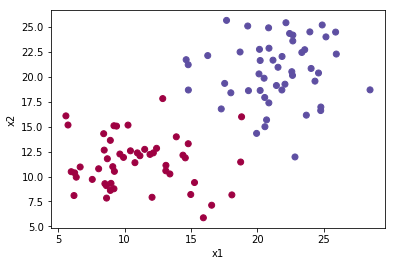

In [18]:
m = 100
X = np.ones([2, m]) + 10
X[:, m // 2:] += 10
X += np.random.randn(X.shape[0], X.shape[1]) * 3
Y = np.hstack([np.zeros((1, m // 2)), np.ones((1, m // 2))])

plt.scatter(X[0, :], X[1, :], c=Y, cmap=plt.cm.Spectral)
plt.ylabel('x2')
plt.xlabel('x1')

In [23]:
x = Variable(np.ones((2, 100)))
w = Variable(np.ones((10, 2)))
b = Variable(np.ones((10, 1)))

z = w.dot(x) + b
dx, dw, db = z.deriv(x), z.deriv(w), z.deriv(b)

zval = z.eval({})
dxval, dwval, dbval = dx.eval({}), dw.eval({}), db.eval({})

# print(dxval.shape, dwval.shape, dbval.shape)
# assert dxval.shape == (2, 100)
# assert dwval.shape == (10, 2)

(10, 2) (2, 100)
(10, 1) (2, 100)
(2, 100) (10, 2)
(10, 1) (10, 2)
(2, 100) (10, 1)
(10, 2) (10, 1)


In [10]:
# a = Const(1)
# b = Variable(2)

# c = a + b
# d = c + c

# loss = d

# # sess = Session()
# # sess.run([d, d, d])

learning_rate = 0.1
steps = 10

A0 = Const(X)
Z1 = dense(A0, input_dim=X.shape[0], output_dim=20)
A1 = ReLU(Z1)
Z2 = dense(A1, input_dim=20, output_dim=10)
A2 = ReLU(Z2)
Z3 = dense(A2, input_dim=10, output_dim=1)  
A3 = Sigmoid(Z3)
Y_hat = A3

loss = LogisticLoss(A=Y_hat, Y=Const(Y))
train = GradientDescentOptimizer(learning_rate, loss)

assert len(loss.variables) == 2 * 3

sess = Session()
print('loss: %f' % sess.run([loss])[0])

for i in range(0, steps):
  _, l = sess.run([train, loss])
  print('step: %d, loss: %f' % (i, l))

loss: 0.693143


TypeError: eval() missing 1 required positional argument: 'cache'